In [32]:
%cd ..

/home/pauline/Dokumente/Delab_Projekt/delab


In [33]:
import pandas as pd

In [65]:
from util.sql_switch import get_query_native

#select all authors from the database

authors_tweets = get_query_native(
    "SELECT ta.id as author_id, conversation_id, screen_name , is_climate_author, climate_author_type FROM delab_tweet t, delab_tweetauthor ta WHERE t.author_id=ta.twitter_id")
#select only authors that are 'climate auhtors'
clauthors_tweets = authors_tweets.loc[authors_tweets['is_climate_author']== True]
clauthors_tweets = clauthors_tweets.replace(['non-governmental organisation'], 'NGO')

#group author by auhtor and conversations in order to analize the calculated variables for each author in each conversation
clauthors_tweets = clauthors_tweets.groupby(["author_id", "screen_name", "climate_author_type","conversation_id"]).mean()

#get needed variables from 'conversation' and 'conversation author metrics'
c_cam = get_query_native(
    "SELECT author_id, is_root_author, c.conversation_id, depth, branching_factor, centrality, baseline_vision, n_posts, root_dominance FROM delab_conversation c, delab_conversationauthormetrics cam WHERE c.conversation_id=cam.conversation_id")
c_cam = c_cam.groupby(["author_id", "conversation_id"]).mean()

#join both dataframes in order to match the climate author type with variables we want to analyze
analysis = clauthors_tweets.join(c_cam)
analysis_flattened = analysis.reset_index()
analysis_flattened

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance
0,1,1414150136607948808,mnyomb1,activist,1.0,0.0,15.0,793.0,0.000000,0.093750,1.0,794.0
1,1,1427328275773280265,mnyomb1,activist,1.0,0.0,9.0,589.0,3.000000,0.093750,1.0,590.0
2,1,1509780204948017154,mnyomb1,activist,1.0,0.0,21.0,320.0,1.666667,0.075195,2.0,321.0
3,1,1521343957086740486,mnyomb1,activist,1.0,0.0,3.0,31.0,0.000000,0.093750,1.0,32.0
4,1,1532708095704580100,mnyomb1,activist,1.0,0.0,10.0,334.0,2.000000,0.093750,1.0,335.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9137,1618,1610320983872634881,climate_ice,scientist,1.0,1.0,4.0,6.0,2.166667,0.285156,2.0,7.0
9138,1619,1519656711455313921,EricTopol,scientist,1.0,1.0,3.0,8.0,6.500000,0.500000,1.0,9.0
9139,1619,1530931490636255232,EricTopol,scientist,1.0,1.0,7.0,35.0,21.166667,0.250000,1.0,36.0
9140,1619,1593290345646694401,EricTopol,scientist,1.0,1.0,10.0,46.0,22.722222,0.500000,1.0,47.0


In [66]:
import networkx as nx

In [68]:
#calculate the total amount of tweets in each conversation
tweet_ids = get_query_native(
                "SELECT conversation_id FROM delab_tweet")
tweet_ids
tweet_count = tweet_ids['conversation_id'].value_counts()
tweet_count = tweet_count.to_frame()
tweet_count = tweet_count.rename(columns={"conversation_id":"n_posts"})
tweet_count['conversation_id'] = tweet_count.index
tweet_count

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,n_posts,conversation_id
1603181423787380737,190875,1603181423787380737
1608175680407191552,81226,1608175680407191552
1612973043583696897,77559,1612973043583696897
1607677190254235648,75456,1607677190254235648
1608188826291167242,43518,1608188826291167242
...,...,...
1590630950870056960,6,1590630950870056960
1593152023142322177,6,1593152023142322177
1618335402338975744,6,1618335402338975744
1593620129073418240,6,1593620129073418240


In [69]:
#add the total amount of tweets to the previous dataframe
mapped_columns = dict(zip(tweet_count.conversation_id, tweet_count.n_posts))
analysis_flattened["total_counts"] = analysis_flattened["conversation_id"].map(mapped_columns)
analysis_flattened

,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
0,1,1414150136607948808,mnyomb1,activist,1.0,0.0,15.0,793.0,0.000000,0.093750,1.0,794.0,794
1,1,1427328275773280265,mnyomb1,activist,1.0,0.0,9.0,589.0,3.000000,0.093750,1.0,590.0,590
2,1,1509780204948017154,mnyomb1,activist,1.0,0.0,21.0,320.0,1.666667,0.075195,2.0,321.0,321
3,1,1521343957086740486,mnyomb1,activist,1.0,0.0,3.0,31.0,0.000000,0.093750,1.0,32.0,32
4,1,1532708095704580100,mnyomb1,activist,1.0,0.0,10.0,334.0,2.000000,0.093750,1.0,335.0,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,1618,1610320983872634881,climate_ice,scientist,1.0,1.0,4.0,6.0,2.166667,0.285156,2.0,7.0,7
9138,1619,1519656711455313921,EricTopol,scientist,1.0,1.0,3.0,8.0,6.500000,0.500000,1.0,9.0,9
9139,1619,1530931490636255232,EricTopol,scientist,1.0,1.0,7.0,35.0,21.166667,0.250000,1.0,36.0,36
9140,1619,1593290345646694401,EricTopol,scientist,1.0,1.0,10.0,46.0,22.722222,0.500000,1.0,47.0,47


In [71]:
#count how many conversation for each climate author type were downloaded
most_count = analysis_flattened.groupby('climate_author_type').count()
most_count

,author_id,conversation_id,screen_name,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
climate_author_type,,,,,,,,,,,,
NGO,1973,1973,1973,1973,1966,1966,1966,1966,1966,1966,1966,1973
activist,1336,1336,1336,1336,1311,1311,1311,1311,1311,1311,1311,1336
journalist,970,970,970,970,966,966,966,966,966,966,966,970
organisation,1332,1332,1332,1332,1331,1331,1331,1331,1331,1331,1331,1332
politician,1185,1185,1185,1185,1180,1180,1180,1180,1180,1180,1180,1185
scientist,2346,2346,2346,2346,2334,2334,2334,2334,2334,2334,2334,2346


## Analyse
- Nach climate_author_type analysieren
- Fragen:
    - in wievielen Konversationen sind die Autoren durchschnittlich vertreten?
    - welche Zentralität haben die AUtoren durchschnittlich?
    - welche root dominance haben die Autoren durchschnittlich?
    - welchen branching_factor und welche depth haben die Konversationen, in denen die Autoren root auhtor sind duchschnittlich?
    

In [72]:
#group the previous dataframe by climate author type to analyze by author type
climate_analysis = analysis_flattened.groupby(['climate_author_type']).mean()
climate_analysis = climate_analysis.drop(columns=['author_id', 'conversation_id', 'is_climate_author', 'is_root_author' ])
climate_analysis

,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
climate_author_type,,,,,,,
NGO,7.079858,135.201424,29.723648,0.349846,1.922686,136.061569,151.692347
activist,11.063310,355.429443,82.601103,0.308685,3.088482,356.358704,848.776198
journalist,8.302277,103.347826,15.675375,0.284783,3.106625,104.347826,126.280412
organisation,4.037566,34.734035,20.843773,0.446987,1.758077,35.674052,36.090841
politician,7.294068,182.557627,80.688418,0.364617,1.803390,183.557627,273.590717
scientist,9.828620,168.356470,33.919878,0.292378,2.949871,169.333023,240.592072


In [73]:
#same with median to compare to mean
median_analysis = analysis_flattened.groupby(['climate_author_type']).median()
median_analysis = median_analysis.drop(columns=['author_id', 'conversation_id', 'is_climate_author', 'is_root_author' ])
median_analysis

,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
climate_author_type,,,,,,,
NGO,4.0,16.0,7.000000,0.500000,1.0,17.0,17.0
activist,8.0,61.0,10.500000,0.285156,1.0,62.0,65.0
journalist,6.0,24.0,6.000000,0.250000,1.0,25.0,26.0
organisation,3.0,12.0,9.000000,0.500000,1.0,13.0,14.0
politician,5.0,24.0,9.437500,0.500000,1.0,25.0,26.0
scientist,7.0,37.0,7.630952,0.250000,1.0,38.0,39.0


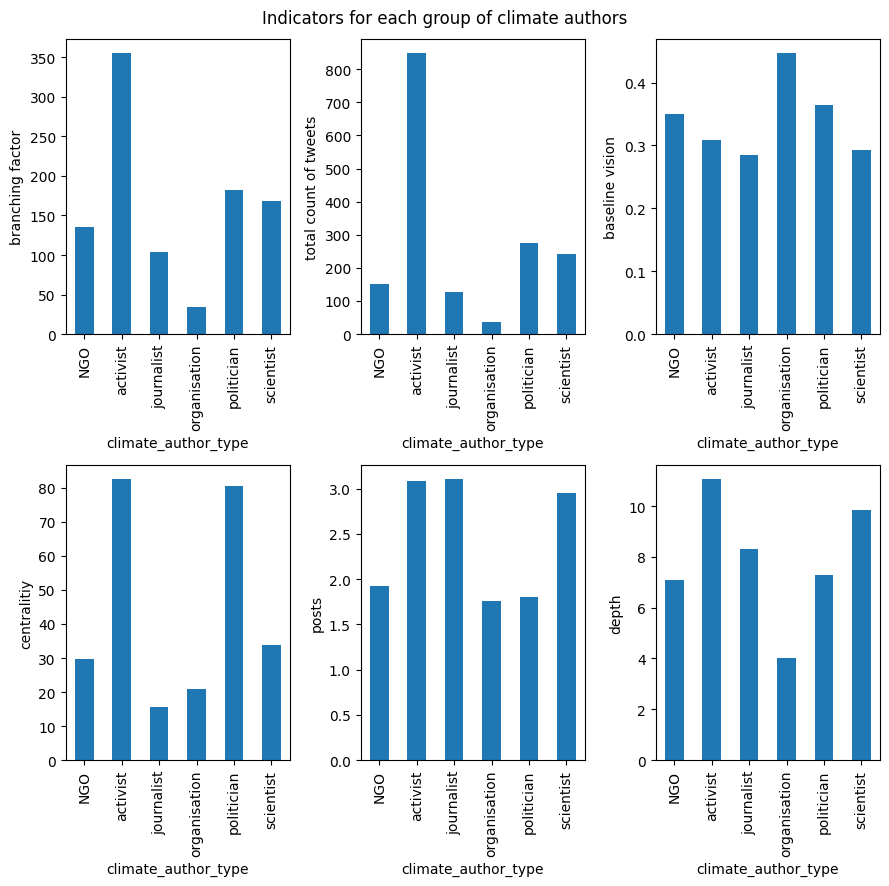

In [77]:
#plot mean of all conversations grouped by climate author type
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))
fig.suptitle("Indicators for each group of climate authors")

ax1 = climate_analysis['branching_factor'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = climate_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = climate_analysis['centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = climate_analysis['n_posts'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("posts");

ax5 = climate_analysis['baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = climate_analysis['depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth");

In [78]:
analysis_flattened.describe()

,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
count,9088.000000,9.088000e+03,9088.0,9088.000000,9088.000000,9088.000000,9088.000000,9088.000000,9088.000000,9088.000000,9088.000000
mean,383.391505,1.454018e+18,1.0,0.869828,8.072623,163.534441,42.252810,0.338378,2.440911,164.479175,164.790493
std,237.245027,1.539065e+17,0.0,0.336511,8.509849,563.514626,175.126455,0.181909,4.720192,563.529108,563.632729
min,1.000000,3.629063e+17,1.0,0.000000,2.000000,5.000000,0.000000,0.012893,1.000000,0.019231,6.000000
25%,317.000000,1.386644e+18,1.0,1.000000,3.000000,10.000000,4.000000,0.142578,1.000000,11.000000,11.000000
50%,375.000000,1.502918e+18,1.0,1.000000,5.000000,24.000000,8.000000,0.500000,1.000000,25.000000,25.000000
75%,401.000000,1.575556e+18,1.0,1.000000,10.000000,85.000000,20.585948,0.500000,2.000000,86.000000,86.000000
max,1619.000000,1.622933e+18,1.0,1.000000,113.000000,13789.000000,6652.180455,0.500000,113.000000,13790.000000,13790.000000


Following cells are to analysize wether dividing the variables by the total amount of tweets decreases the amount of outliers (it does).

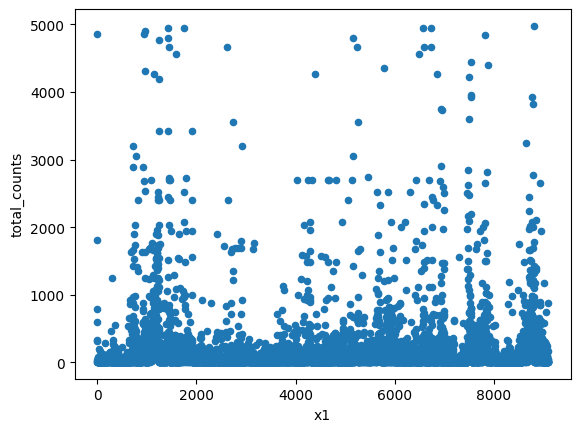

In [96]:
scatter_analysis = analysis_flattened.reset_index()
scatter_analysis = scatter_analysis[scatter_analysis.total_counts > 1]
scatter_analysis = scatter_analysis.drop(scatter_analysis[scatter_analysis['total_counts']>5000].index)
scatter_analysis['x1'] = scatter_analysis.index
scatter_analysis = scatter_analysis.sort_values('total_counts', ascending=True)
scatter_analysis
scatter_analysis.plot.scatter(x='x1', y="total_counts");

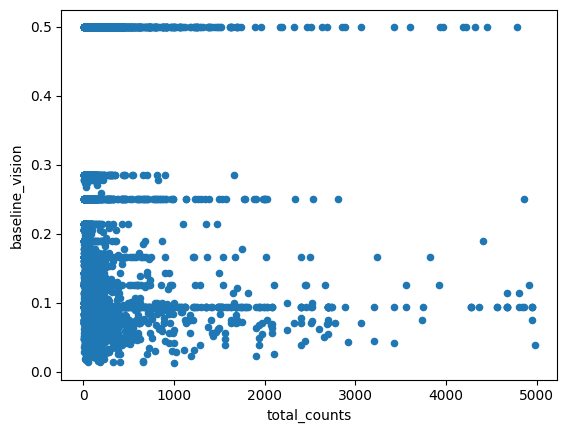

In [95]:
std = scatter_analysis['baseline_vision']
scatter_analysis.plot.scatter(x='total_counts', y= 'baseline_vision');

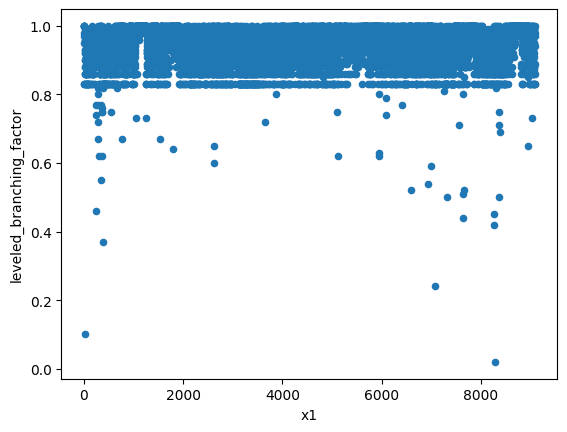

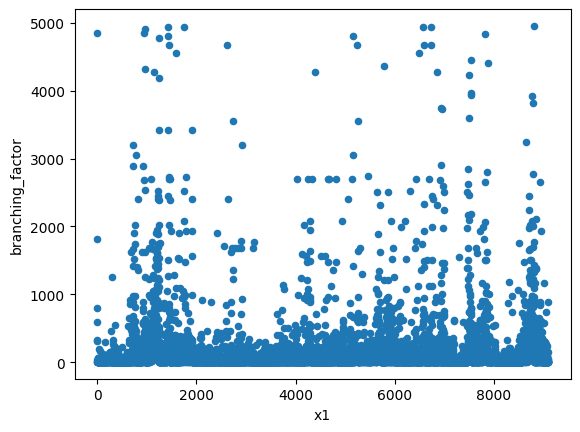

In [94]:
scatter_analysis['leveled_branching_factor']= (scatter_analysis["branching_factor"]/scatter_analysis["total_counts"]).round(2)
scatter_analysis.plot.scatter(x='x1', y="leveled_branching_factor")
scatter_analysis.plot.scatter(x='x1', y="branching_factor");

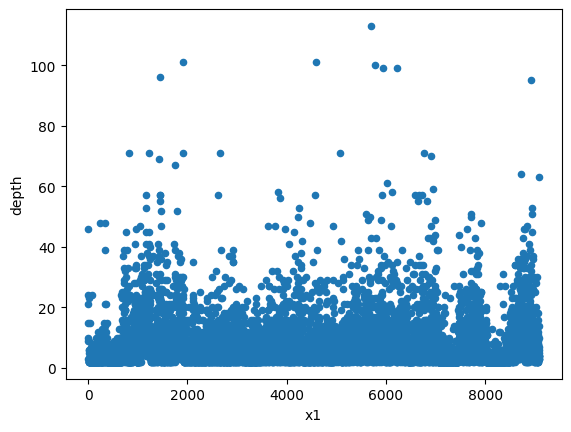

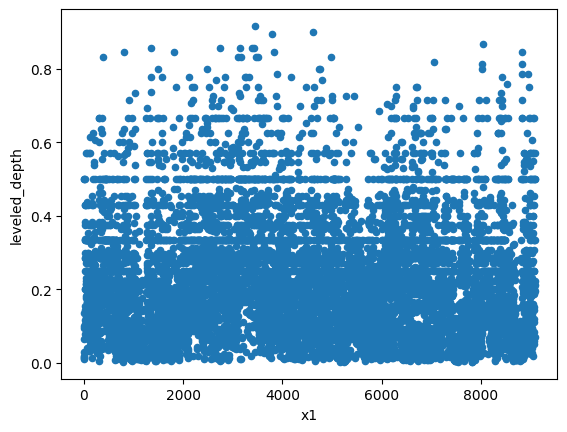

In [106]:
scatter_analysis.plot.scatter(x='x1', y="depth")
scatter_analysis['leveled_depth']= (scatter_analysis["depth"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_depth");

In [107]:
scatter_analysis

,index,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_centrality,leveled_baseline_vision,leveled_posts,leveled_dominance,leveled_depth
6274,6296,390,1416369286097129478,chri_gru,scientist,1.0,1.0,3.0,5.0,0.666667,0.142578,3.0,0.500000,6,6274,0.500000,0.023763,0.500000,1.000000,0.500000
2834,2848,344,1124663673933451266,fff_hamburg,NGO,1.0,1.0,3.0,5.0,3.500000,0.500000,1.0,0.166667,6,2834,0.500000,0.083333,0.166667,1.000000,0.500000
8159,8206,434,1548940857084182530,UNEP,organisation,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,0.166667,6,8159,0.333333,0.083333,0.166667,1.000000,0.333333
795,799,286,1589319384220446720,mikaelaloach,activist,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,0.166667,6,795,0.333333,0.083333,0.166667,1.000000,0.333333
4686,4706,377,1401869295731150850,micha_bloss,politician,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,0.166667,6,4686,0.333333,0.083333,0.166667,1.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,1769,310,1596441230644477954,NurderK,activist,1.0,0.0,31.0,4940.0,89.130042,0.075195,2.0,0.000405,4941,1758,0.006274,0.000015,0.000405,1.000000,0.006274
1438,1449,305,1596441230644477954,Perowinger94,activist,1.0,0.0,31.0,4940.0,29.975000,0.093750,1.0,0.000202,4941,1438,0.006274,0.000019,0.000202,1.000000,0.006274
6571,6595,392,1596441230644477954,sascha_m_k,scientist,1.0,0.0,31.0,4940.0,12.000000,0.093750,1.0,0.000202,4941,6571,0.006274,0.000019,0.000202,1.000000,0.006274
6732,6756,396,1596441230644477954,ConstZerger,scientist,1.0,0.0,31.0,4940.0,0.000000,0.093750,1.0,0.000202,4941,6732,0.006274,0.000019,0.000202,1.000000,0.006274


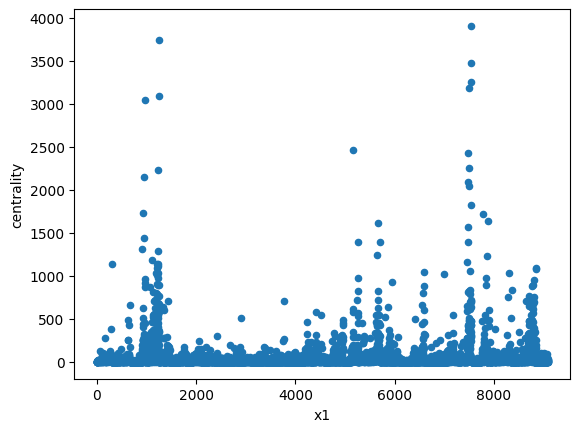

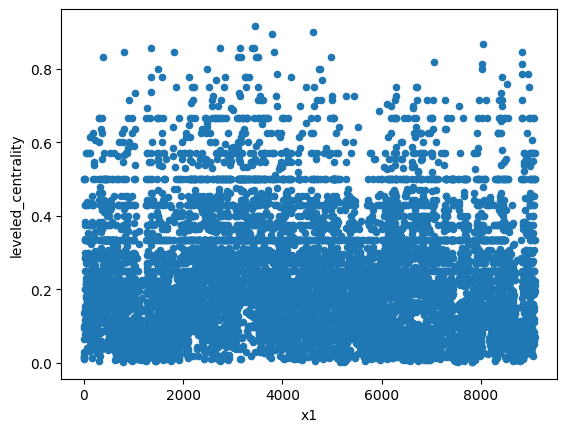

In [97]:
scatter_analysis.plot.scatter(x='x1', y="centrality")
scatter_analysis['leveled_centrality']= (scatter_analysis["depth"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_centrality");

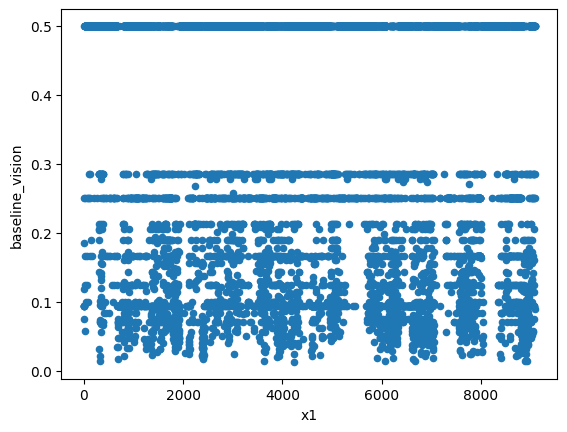

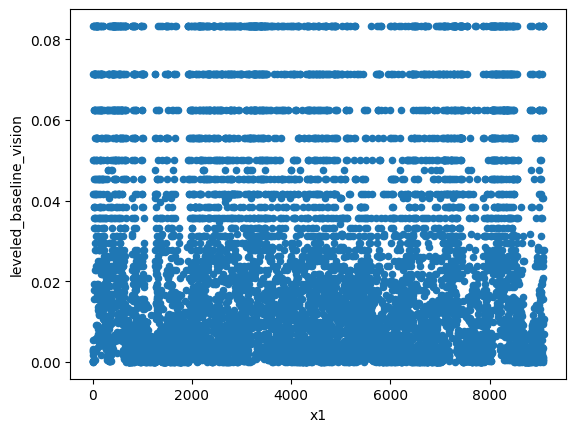

In [98]:
scatter_analysis.plot.scatter(x='x1', y="baseline_vision")
scatter_analysis['leveled_baseline_vision']= (scatter_analysis["baseline_vision"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_baseline_vision");

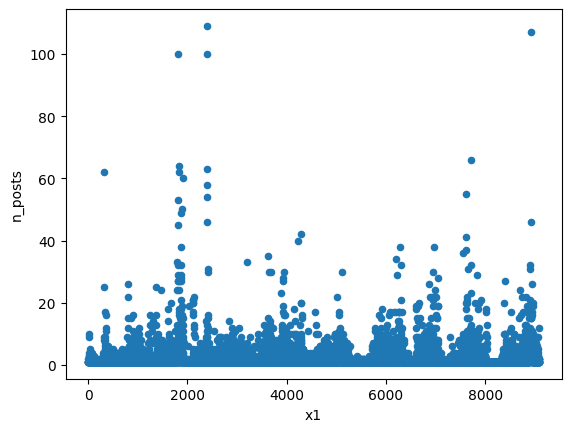

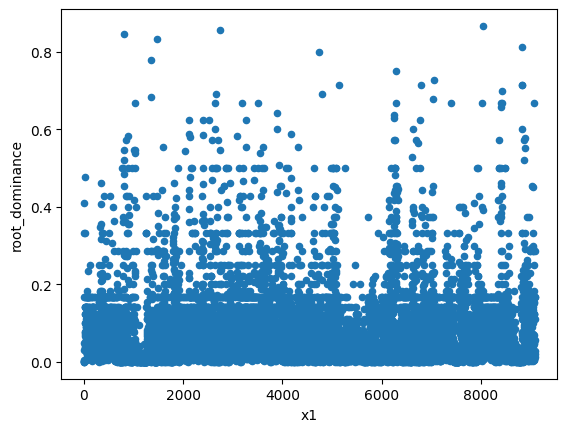

In [101]:
#n_posts divided by total counts of posts is the same as the root dominance from the delab_tree library
scatter_analysis.plot.scatter(x='x1', y="n_posts")
scatter_analysis['root_dominance']= (scatter_analysis["n_posts"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="root_dominance");

In [108]:
#group the variables divided by the total count of tweets by climate author type
leveled_analysis = scatter_analysis.groupby('climate_author_type').mean()
leveled_analysis

,index,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_centrality,leveled_baseline_vision,leveled_posts,leveled_dominance,leveled_depth
climate_author_type,,,,,,,,,,,,,,,,,,
NGO,3532.929771,310.992366,1.443481e+18,1.0,0.887532,7.057506,132.414249,29.738775,0.349976,1.923155,0.100391,133.456489,3514.745547,0.251400,0.027568,0.100391,0.991531,0.251400
activist,1953.722180,310.569455,1.440396e+18,1.0,0.817345,10.877206,293.557943,77.965777,0.309807,3.096700,0.072277,294.891021,1942.174213,0.173680,0.013845,0.072277,0.994835,0.173680
journalist,4104.990664,390.545643,1.449929e+18,1.0,0.869295,8.231328,91.379668,15.635078,0.285259,3.104772,0.113898,92.522822,4088.647303,0.259985,0.018914,0.113898,0.999093,0.259985
organisation,5134.008264,323.090909,1.447653e+18,1.0,0.977461,4.037566,34.734035,20.843773,0.446987,1.758077,0.098218,36.110443,5105.515402,0.237247,0.037042,0.098218,0.993023,0.237247
politician,5179.927844,398.578098,1.431114e+18,1.0,0.910017,7.219864,173.339559,80.609047,0.365079,1.792020,0.085483,174.353141,5157.058574,0.216963,0.021618,0.085483,0.999393,0.216963
scientist,6446.628326,508.677682,1.486291e+18,1.0,0.807725,9.763519,159.027897,33.783897,0.292753,2.905150,0.082883,160.523605,6418.904292,0.212541,0.014893,0.082883,0.994287,0.212541


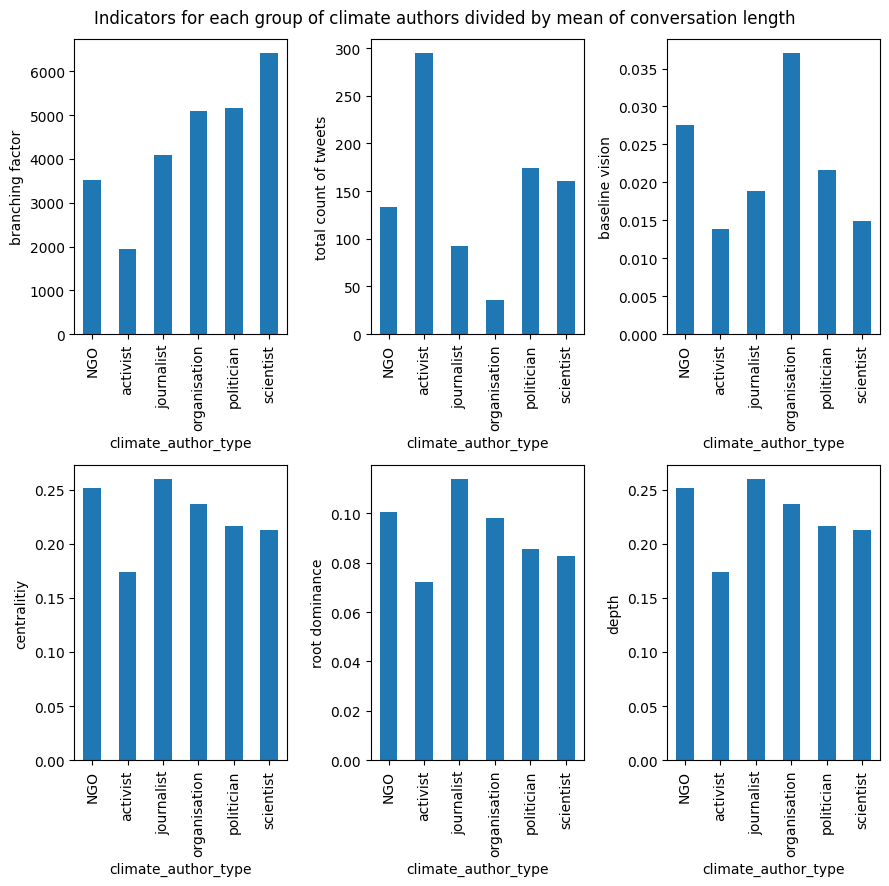

In [109]:
#plot the new dataframe in order to get results less sensitive to outliers
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))
fig.suptitle("Indicators for each group of climate authors divided by mean of conversation length")

ax1 = leveled_analysis['leveled_branching'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = leveled_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = leveled_analysis['leveled_centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = leveled_analysis['leveled_posts'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("root dominance");

ax5 = leveled_analysis['leveled_baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = leveled_analysis['leveled_depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth");